In [1]:
import funcs
import mrsobs

import itertools
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
%autosave 30

Autosaving every 30 seconds


In [3]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

In [5]:
# select band
band = '4C'

# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [14]:
# FM MRS_RAD_11 (observations of internal calibration source in nominal and cross-dichroic configurations)
lvl1path = '/STER/miriman/FM/'
filename_FM = mrsobs.MIRI_internal_calibration_source(lvl1path,band,campaign='FM',output='filename').replace('_LVL2','')
# OTIS internal calibration source observation
filename_OTIS = workDir+'OTIS_data/LVL1/MIRV00331002001P0000000002102_1_494_SE_2017-08-25T20h22m26.fits'
# CV3 MIRM33541 (MRS_RAD_11, observations of internal calibration source in nominal and cross-dichroic configurations)
lvl1path = workDir+'CV3_data/LVL1/'
filename = mrsobs.MIRI_internal_calibration_source(lvl1path,band,campaign='CV3',output='filename').replace('_LVL2','')
# CV3 MIRM108 (MRS_RAD_14, observations of internal calibration source with very long ramps)
lvl1path = workDir+'CV3_data/LVL1/'
filename_NL = mrsobs.MIRI_internal_calibration_source_nonlinearity_correction(lvl1path,band,output='filename').replace('_LVL2','')

image_hdu = fits.open(filename_FM)
image_data = fits.getdata(filename_FM)[:,:1024,:].astype('float')

image_hdu_NL = fits.open(filename_NL)
image_data_NL = fits.getdata(filename_NL)[:,:1024,:].astype('float')

In [15]:
print('----MIRM33541----')
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

print('----MIRM108----')
image_shape_NL = image_data_NL.shape
nints_NL       = image_hdu_NL[0].header['NINT']
ngroups_NL     = image_hdu_NL[0].header['NGROUP']
nframes_NL     = image_shape_NL[0]
readout_NL     = image_hdu_NL[0].header['READOUT']
frame_delta_time_NL = image_hdu_NL[0].header['TFRAME']
print('Number of integrations: {}'.format(nints_NL))
print('Number of groups/frames per integration: {}'.format(ngroups_NL))
print('Total number of frames: {}'.format(nframes_NL))
print('Readout: {}'.format(readout_NL))
print('Time between samples: {} sec'.format(frame_delta_time_NL))
print('LVL1 data shape: {}'.format(image_shape_NL))

----MIRM33541----
Number of integrations: 5
Number of groups/frames per integration: 20
Total number of frames: 100
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (100, 1024, 1032)
----MIRM108----
Number of integrations: 2
Number of groups/frames per integration: 200
Total number of frames: 400
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (400, 1024, 1032)


In [12]:
image_hdu.close()
image_hdu_NL.close()

<IPython.core.display.Javascript object>


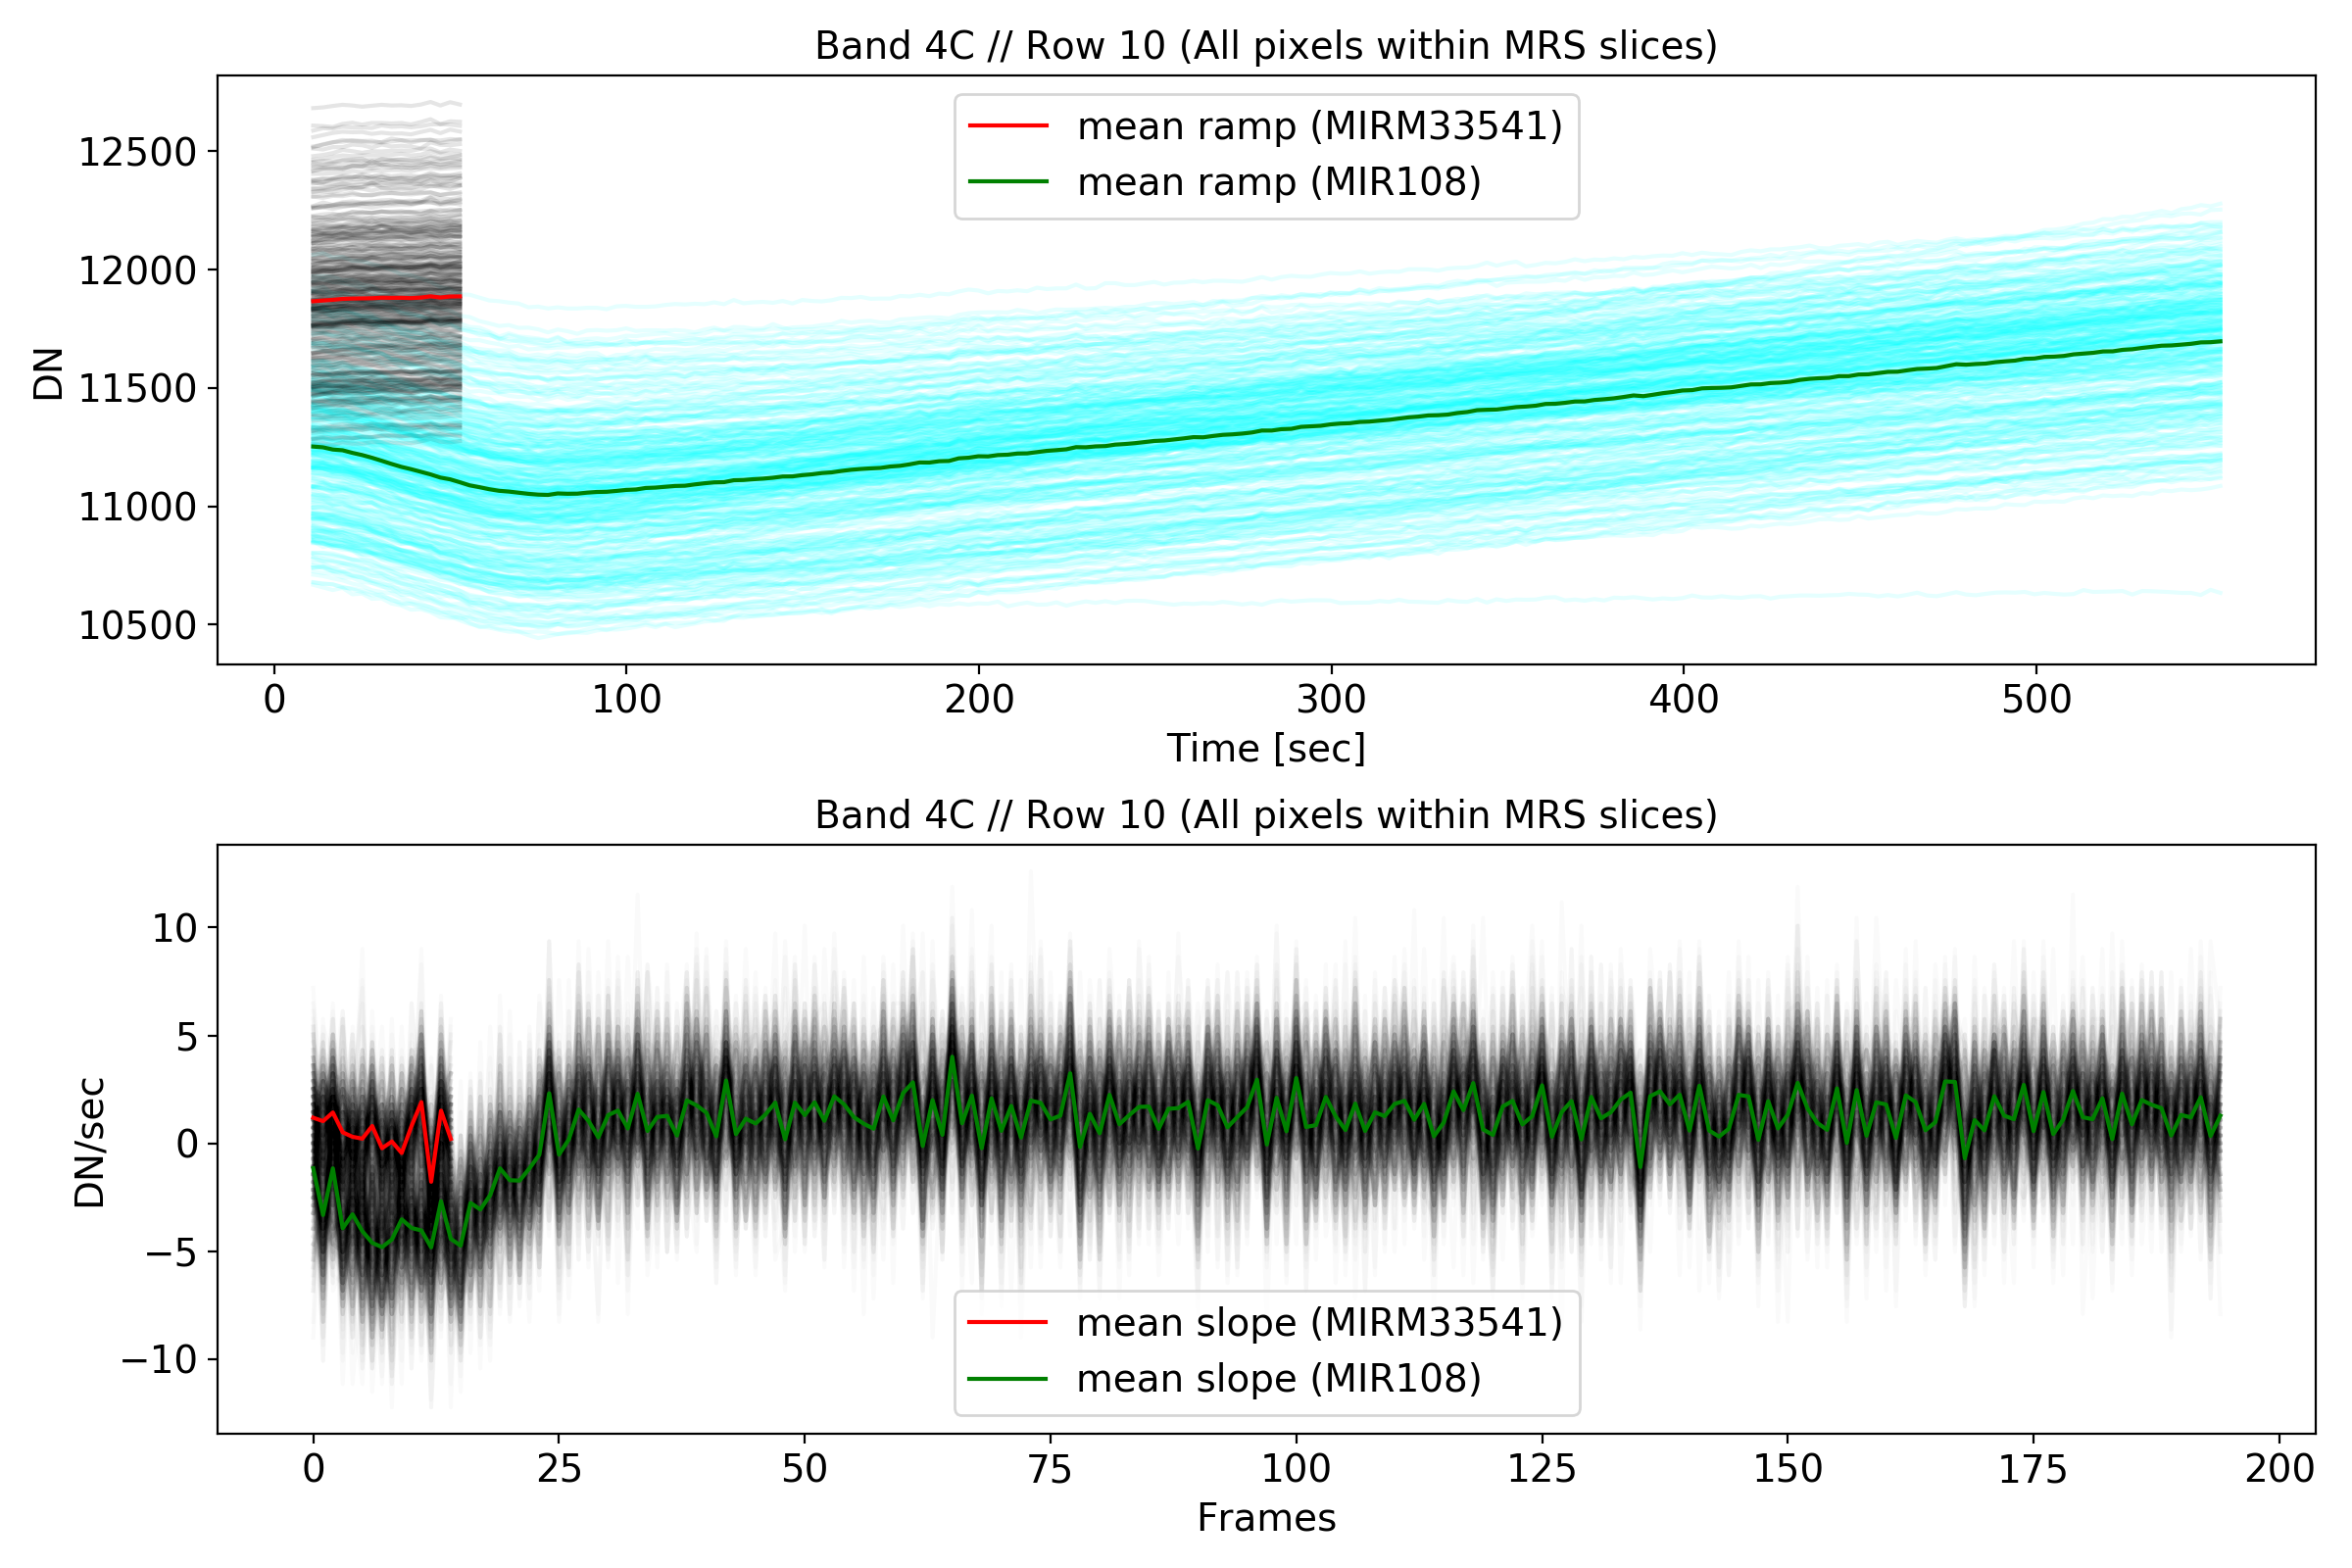

In [16]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
time_NL  = np.arange(1,nframes_NL+1)[(analyze_ramp-1)*ngroups_NL:analyze_ramp*ngroups_NL]*frame_delta_time_NL
ramp_arr,ramp_arr_NL = [],[]
slope_arr,slope_arr_NL = [],[]
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
valid_img = np.zeros(d2cMaps['sliceMap'].shape)
valid_img[d2cMaps['sliceMap']!=0] = 1

fig,axs = plt.subplots(2,1,figsize=(12,8))
for ypos in [10]:
    for xpos in range_x:
        if valid_img[ypos,xpos] == 1:
            tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
            time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
            time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
            ramp_arr.append(tramp3)
            slope_arr.append(np.diff(tramp3)/frame_delta_time)
            
            tramp_NL = image_data_NL[(analyze_ramp-1)*ngroups_NL:analyze_ramp*ngroups_NL,ypos,xpos]
            time2_NL,tramp2_NL = time_NL[skip_first:-skip_last],tramp_NL[skip_first:-skip_last]
            time3_NL,tramp3_NL = time2_NL[tramp2_NL < 58000],tramp2_NL[tramp2_NL < 58000]
            ramp_arr_NL.append(tramp3_NL)
            slope_arr_NL.append(np.diff(tramp3_NL)/frame_delta_time_NL)
            
            
            axs[0].plot(time3,tramp3,'k',alpha=0.1)
            axs[0].plot(time3_NL,tramp3_NL,'cyan',alpha=0.1)
            axs[1].plot(np.diff(tramp3)/frame_delta_time,'k',alpha=0.02)
            axs[1].plot(np.diff(tramp3_NL)/frame_delta_time_NL,'k',alpha=0.02)
ramp_arr = np.array(ramp_arr)
slope_arr = np.array(slope_arr)
ramp_arr_NL = np.array(ramp_arr_NL)
slope_arr_NL = np.array(slope_arr_NL)
axs[0].plot(time3,np.mean(ramp_arr,axis=0),'r',label='mean ramp (MIRM33541)')
axs[1].plot(np.mean(slope_arr,axis=0),'r',label='mean slope (MIRM33541)')

axs[0].plot(time3_NL,np.mean(ramp_arr_NL,axis=0),'g',label='mean ramp (MIR108)')
axs[1].plot(np.mean(slope_arr_NL,axis=0),'g',label='mean slope (MIR108)')
axs[0].set_xlabel('Time [sec]',fontsize=14)
axs[0].set_ylabel('DN',fontsize=14)
axs[1].set_xlabel('Frames',fontsize=14)
axs[1].set_ylabel('DN/sec',fontsize=14)
for plot in range(2):
    axs[plot].legend(fontsize=14)
    axs[plot].set_title('Band {} // Row {} (All pixels within MRS slices)'.format(band,ypos),fontsize=14)
    axs[plot].tick_params(axis='both',labelsize=14)
plt.tight_layout()


### Remarks:
* Taking a less than 30 frame exposure makes one mistakenly think that the slope is negative. The real situation is revealed when seeing the  more than 30 frame exposure. In this instance, from an estimated signal of -4 DN/sec in the less than 30 frame case, one finds a signal of 1DN/sec in the more than 30 frame case.